In [1]:
import os
import pandas as pd

In [18]:
# Get list of files
list_res = os.listdir('final/polblogs/')
print(list_res)

['polblogs_woVIB_GCN2022-10-06_10:55:39.txt', 'polblogs_GAT_woVIB_final.txt', 'polblogs_MLP_2022-10-05_13:53:43.txt', 'polblogs_VIB_all_2022-10-06_10:43:14.txt']


In [20]:
# Parser
def parse_line(line):
    line = line.replace("\t", ",")
    # dirty
    # position = 71
    # new_character = "-"
    # line = line[:position] + new_character + line[position + 1:]
    m = {}
    for part in line.split(","):
        name, value = part.split("=")
        if name == "TIME":
            continue
        m[name] = value
    return m

results = []

with open('final/polblogs/polblogs_GAT_woVIB_final.txt', encoding="latin-1") as f:
    for line in f:
        info = parse_line(line)
        results.append(info)

In [21]:
f = pd.DataFrame(results)
print(f.head())

    ALPHA            LR EPOCH ENCODER HIDDEN CHANNELS NUM LAYERS SEED  \
0  0.0000  1.000000e-02   300     GAT       [256-128]          2   56   
1  0.0000  1.000000e-02   300     GAT       [256-128]          3   56   
2  0.0000  1.000000e-02   300     GAT       [256-256]          2   56   
3  0.0000  1.000000e-02   300     GAT       [256-256]          3   56   
4  0.1000  1.000000e-02   300     GAT       [256-128]          2   56   

       AUC       DI       EO       RB DURATION  
0  0.92212  0.28506  0.22041  0.92328  24.60\n  
1  0.80103  0.65901  0.23250  0.90946  36.69\n  
2  0.91176  0.28630  0.24864  0.93130  32.13\n  
3  0.79077  0.62918  0.36942  0.89500  45.43\n  
4  0.92334  0.30663  0.19984  0.90974  21.48\n  


In [22]:
# Versions with VIB 
def extract_best(results, encoder):
    
    f = pd.DataFrame(results)
    #print(f.head())
   
    f.columns = ['ALPHA', 'LR', 'EPOCH', 'ENCODER', 'HIDDEN CHANNELS', 'NUM LAYERS', 'SEED', 'AUC','DI', 'EO', 'RB', 'DURATION']
    
    
    f.reset_index(inplace=True)
    f.drop("index",axis=1,inplace=True)
    
    #f = f.astype({'ALPHA':'float', 'AUC': 'float', 'DI': 'float', 'EO': 'float', 'RB': 'float', 
    #              'EPOCH': 'int', 'LR':'float', 'L': 'int', 'BETA':'float'})
    
    #FIPR
    f = f.astype({'ALPHA':'float', 'AUC': 'float', 'NUM LAYERS':'int', 'DI': 'float', 'EO': 'float', 'RB': 'float', 
                  'EPOCH': 'int', 'LR':'float', 'EPOCH':'int'})
    
    # Compute harmonic mean and average 
    f['1-RB'] = 1-f['RB']
    f['avg_RB_AUC'] = f[['AUC', '1-RB']].mean(axis=1)
    f['avg_DI_AUC'] = f[['AUC', 'DI']].mean(axis=1)
    f['fscore'] = 2*(f['AUC']*f['DI'])/(f['AUC']+f['DI'])
    f['fscorebis'] = 2*(f['AUC']*f['DI']*f['1-RB'])/(f['AUC']+f['DI']+f['1-RB'])
    
    print(f.columns)
      
    res = f[f['ENCODER'] == encoder]  
    #res = res[res['NUM LAYERS'] == 2]  
    #res = res[res['HIDDEN CHANNELS']=='[128-128]']
    res_filtered = res
    
    # Average on seeds 
    # mean = res_filtered.groupby(['ALPHA', 'HIDDEN CHANNELS', 'EPOCH', 'LR', 'NUM LAYERS', 'L', 'BETA'], 
    #                     as_index=False)[['fscore', 'fscorebis', 'AUC', 'DI', 'EO', 'RB']].mean()
    #mean = res_filtered.groupby(['ALPHA', 'HIDDEN CHANNELS', 'EPOCH', 'LR', 'BETA', 'L'], 
    #                     as_index=False)[['fscore', 'fscorebis', 'AUC', 'DI', 'EO', 'RB']].mean()
    
    mean = res_filtered.groupby(['ALPHA', 'HIDDEN CHANNELS', 'EPOCH', 'LR', 'NUM LAYERS'], 
                                as_index=False)[['fscore', 'fscorebis', 'AUC', 'DI', 'EO', 'RB']].mean()
    
    # Standard deviation on seeds
    #std = res_filtered.groupby(['ALPHA', 'HIDDEN CHANNELS', 'EPOCH', 'LR', 'BETA', 'L'], 
    #                     as_index=False)[['fscore', 'fscorebis', 'AUC', 'DI', 'EO', 'RB']].std()
    std = res_filtered.groupby(['ALPHA', 'HIDDEN CHANNELS', 'EPOCH', 'LR', 'NUM LAYERS'], 
                               as_index=False)[['fscore', 'fscorebis', 'AUC', 'DI', 'EO', 'RB']].std()

    
    # Get the best set of hyper-parameter (max harmonic mean between DI and AUC)
    best_set =  mean[mean.fscore == mean.fscore.max()]
    
    print(best_set)


    # Extract all info for this particular set of hype-parameters 
    _temp1 = mean[(mean['LR'] == best_set.iloc[0]['LR'])&
                         (mean['HIDDEN CHANNELS'] == best_set.iloc[0]['HIDDEN CHANNELS'])&(
                  mean['NUM LAYERS'] == best_set.iloc[0]['NUM LAYERS'])]
    _temp2 = std[(std['LR'] == best_set.iloc[0]['LR'])&
                         (std['HIDDEN CHANNELS'] == best_set.iloc[0]['HIDDEN CHANNELS'])&(
                  std['NUM LAYERS'] == best_set.iloc[0]['NUM LAYERS'])]
   
    return _temp1, _temp2

In [23]:
avg, std = extract_best(results, 'GAT')

Index(['ALPHA', 'LR', 'EPOCH', 'ENCODER', 'HIDDEN CHANNELS', 'NUM LAYERS',
       'SEED', 'AUC', 'DI', 'EO', 'RB', 'DURATION', '1-RB', 'avg_RB_AUC',
       'avg_DI_AUC', 'fscore', 'fscorebis'],
      dtype='object')
    ALPHA HIDDEN CHANNELS  EPOCH    LR  NUM LAYERS    fscore  fscorebis  \
35    0.8       [256-256]    300  0.01           3  0.805227   0.151271   

         AUC        DI        EO        RB  
35  0.768746  0.873378  0.028822  0.787898  


In [24]:
print(avg)

    ALPHA HIDDEN CHANNELS  EPOCH    LR  NUM LAYERS    fscore  fscorebis  \
3     0.0       [256-256]    300  0.01           3  0.681463   0.062511   
7     0.1       [256-256]    300  0.01           3  0.740952   0.067939   
11    0.2       [256-256]    300  0.01           3  0.738677   0.082298   
15    0.3       [256-256]    300  0.01           3  0.689948   0.067228   
19    0.4       [256-256]    300  0.01           3  0.673937   0.055728   
23    0.5       [256-256]    300  0.01           3  0.723759   0.058722   
27    0.6       [256-256]    300  0.01           3  0.722145   0.061086   
31    0.7       [256-256]    300  0.01           3  0.758673   0.076085   
35    0.8       [256-256]    300  0.01           3  0.805227   0.151271   
39    0.9       [256-256]    300  0.01           3  0.653002   0.241130   

         AUC        DI        EO        RB  
3   0.830234  0.579304  0.259474  0.902228  
7   0.811536  0.687128  0.167306  0.902496  
11  0.802656  0.705724  0.121522  0.879

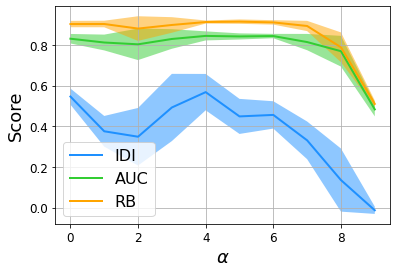

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Visualisation of the impact of alpha
Nsteps, Nwalkers = 10, 10
t = np.arange(Nsteps)

# Nsteps length arrays empirical means and standard deviations of both
# populations over time
DI = np.log(1/np.array(avg.DI))
DIsigma = np.array(std.DI)

AUC = np.array(avg.AUC)
AUCsigma = np.array(std.AUC)

RB = np.array(avg.RB)
RBsigma = np.array(std.RB)

label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
# plot it!
fig, ax = plt.subplots(1)
ax.plot(t, DI, lw=2, label='IDI', color='dodgerblue')
ax.plot(t, AUC, lw=2, label='AUC', color='limegreen')
ax.plot(t, RB, lw=2, label= 'RB', color='orange')
ax.fill_between(t, DI+DIsigma, DI-DIsigma, facecolor='dodgerblue', alpha=0.5)
ax.fill_between(t, AUC+AUCsigma, AUC-AUCsigma, facecolor='limegreen', alpha=0.5)
ax.fill_between(t, RB+RBsigma, RB-RBsigma, facecolor='orange', alpha=0.5)
#ax.set_title(r'random walkers empirical $\mu$ and $\pm \sigma$ interval')
ax.legend(loc='lower left', fontsize=16)
ax.set_xlabel(r'$\alpha$', fontsize=18)
ax.set_ylabel('Score', fontsize=18)
ax.grid()
plt.savefig('polblogs_wo_GAT.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.markers import MarkerStyle
# POLBLOGS VISUALISATION

# AUC vs DI
# GAT, GCN, GAT-FIPR, GCN-FIPR, us

y = np.array([0.91, 0.89, 0.80, 0.78, 0.85, 0.87, 0.82, 0.83])
x = np.array([0.38, 0.48, 0.89, 0.95, 0.91, 0.79, 0.92, 0.99])
z = np.array([0.92, 0.87, 0.71, 0.62, 0.74, 0.78, 0.55, 0.64])

# Lastfm
auc_lastfm = np.array([0.92, 0.92468, 0.8322, 0.809772, 0.812964, 0.870162, 0.86324, 0.81808])
# DI
di_lastfm = np.array([0.24, 0.18856, 0.860872, 0.866684, 0.830372, 0.753278, 0.96522, 0.99492])
# RB
rb_lastfm = np.array([0.78, 0.73364, 0.725896 , 0.660502,0.650434 ,0.675084 , 0.62471, 0.58901])

# Facebook
auc_fb = np.array([0.94, 0.88686, 0.822410, 0.80201, 0.8096, 0.83703 , 0.86578, 0.89157])
# DI
di_fb = np.array([0.27, 0.47503, 0.921360, 0.923346, 0.93579, 0.74564, 0.97767, 0.97979 ])
# RB
rb_fb = np.array([0.78, 0.69700,  0.623610 , 0.571044, 0.67553, 0.62050, 0.62479, 0.68785])


color = ['purple', 'orange', 'lightgreen', 'blue', 'orange', 'purple', 'green', 'yellow']
mark = ["^", "o", "^", "o", "^" , "o", "^", "o"]


fig, axs = plt.subplots(2,3, figsize=(17,8))

#### POLBLOGS AUC vs DI
ax = axs[0][0]
ax.scatter(x[0], y[0], s=250, c= 'white', edgecolor='darkgray', marker="o", label='GAT')
ax.scatter(x[1], y[1], s=250, c='white', edgecolor='darkgray', marker="^", label='GCN')

ax.scatter(x[2], y[2], s=250, c=color[0], edgecolor=color[0], marker="o", label = 'GAT-FIPR')
ax.scatter(x[3], y[3], s=250, c =color[0], edgecolor=color[0], marker="^", label = 'GCN-FIPR')

ax.scatter(x[4], y[4], s=250, c=color[1], edgecolor=color[1], marker=MarkerStyle("o", fillstyle="right"))
ax.scatter(x[4], y[4], s=250, c = 'white', edgecolor=color[1], marker=MarkerStyle("o", fillstyle="left"))

ax.scatter(x[5], y[5], s=250, c=color[2], edgecolor=color[2], marker=MarkerStyle("^", fillstyle="right"))
ax.scatter(x[5], y[5], s=250, c = 'white', edgecolor=color[2], marker=MarkerStyle("^", fillstyle="left"))

ax.scatter(x[6], y[6], s=250, c=color[1], edgecolor=color[1], marker="o")
ax.scatter(x[7], y[7], s=250, c=color[2], edgecolor=color[2], marker="^")

#ax.errorbar(x, y, xerr=y_err, fmt=' ')
ax.set_xlabel("DI", fontsize=16)
ax.set_ylabel("AUC", fontsize=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

#### LASTFM AUC vs DI

ax = axs[0][1]
ax.scatter(di_lastfm[0], auc_lastfm[0], s=250, c= 'white', edgecolor='darkgray', marker="o", label='GAT')
ax.scatter(di_lastfm[1], auc_lastfm[1], s=250, c='white', edgecolor='darkgray', marker="^", label='GCN')

ax.scatter(di_lastfm[2], auc_lastfm[2], s=250, c=color[0], edgecolor=color[0], marker="o", label = 'GAT-FIPR')
ax.scatter(di_lastfm[3], auc_lastfm[3], s=250, c =color[0], edgecolor=color[0], marker="^", label = 'GCN-FIPR')

ax.scatter(di_lastfm[4], auc_lastfm[4], s=250, c=color[1], edgecolor=color[1], marker=MarkerStyle("o", fillstyle="right"))
ax.scatter(di_lastfm[4], auc_lastfm[4], s=250, c = 'white', edgecolor=color[1], marker=MarkerStyle("o", fillstyle="left"))

ax.scatter(di_lastfm[5], auc_lastfm[5], s=250, c=color[2], edgecolor=color[2], marker=MarkerStyle("^", fillstyle="right"))
ax.scatter(di_lastfm[5], auc_lastfm[5], s=250, c = 'white', edgecolor=color[2], marker=MarkerStyle("^", fillstyle="left"))

ax.scatter(di_lastfm[6], auc_lastfm[6], s=250, c=color[1], edgecolor=color[1], marker="o")
ax.scatter(di_lastfm[7], auc_lastfm[7], s=250, c=color[2], edgecolor=color[2], marker="^")

ax.set_xlabel("DI", fontsize=16)

#### FACEBOOK AUC vs DI

ax = axs[0][2]
ax.scatter(di_fb[0], auc_fb[0], s=250, c= 'white', edgecolor='darkgray', marker="o", label='GAT')
ax.scatter(di_fb[1], auc_fb[1], s=250, c='white', edgecolor='darkgray', marker="^", label='GCN')

ax.scatter(di_fb[2], auc_fb[2], s=250, c=color[0], edgecolor=color[0], marker="o", label='GAT-FIPR')
ax.scatter(di_fb[3], auc_fb[3], s=250, c =color[0], edgecolor=color[0], marker="^", label ='GCN-FIPR')

ax.scatter(di_fb[4], auc_fb[4], s=250, c=color[1], edgecolor=color[1], marker=MarkerStyle("o", fillstyle="right"), label='LEAVE-GAT woVIB')
ax.scatter(di_fb[4], auc_fb[4], s=250, c = 'white', edgecolor=color[1], marker=MarkerStyle("o", fillstyle="left"))

ax.scatter(di_fb[5], auc_fb[5], s=250, c=color[2], edgecolor=color[2], marker=MarkerStyle("^", fillstyle="right"), label='LEAVE-GCN woVIB')
ax.scatter(di_fb[5], auc_fb[5], s=250, c = 'white', edgecolor=color[2], marker=MarkerStyle("^", fillstyle="left"))

ax.scatter(di_fb[6], auc_fb[6], s=250, c=color[1], edgecolor=color[1], marker="o", label='LEAVE-GAT')
ax.scatter(di_fb[7], auc_fb[7], s=250, c=color[2], edgecolor=color[2], marker="^", label='LEAVE-GCN')

ax.set_xlabel("DI", fontsize=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# POLBLOGS AUC vs RB
ax = axs[1][0]
ax.scatter(z[0], y[0], s=250, c= 'white', edgecolor='darkgray', marker="o", label='GAT')
ax.scatter(z[1], y[1], s=250, c='white', edgecolor='darkgray', marker="^", label='GCN')

ax.scatter(z[2], y[2], s=250, c=color[0], edgecolor=color[0], marker="o", label='GAT-FIPR')
ax.scatter(z[3], y[3], s=250, c =color[0], edgecolor=color[0], marker="^", label ='GCN-FIPR')

ax.scatter(z[4], y[4], s=250, c=color[1], edgecolor=color[1], marker=MarkerStyle("o", fillstyle="right"), label='LEAVE-GAT woVIB')
ax.scatter(z[4], y[4], s=250, c = 'white', edgecolor=color[1], marker=MarkerStyle("o", fillstyle="left"))

ax.scatter(z[5], y[5], s=250, c=color[2], edgecolor=color[2], marker=MarkerStyle("^", fillstyle="right"), label='LEAVE-GCN woVIB')
ax.scatter(z[5], y[5], s=250, c = 'white', edgecolor=color[2], marker=MarkerStyle("^", fillstyle="left"))

ax.scatter(z[6], y[6], s=250, c=color[1], edgecolor=color[1], marker="o", label='LEAVE-GAT')
ax.scatter(z[7], y[7], s=250, c=color[2], edgecolor=color[2], marker="^", label='LEAVE-GCN')

ax.set_xlabel("RB", fontsize=16)
ax.set_ylabel("AUC", fontsize=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# LASTFM AUC vs RB

ax = axs[1][1]
ax.scatter(rb_lastfm[0], auc_lastfm[0], s=250, c= 'white', edgecolor='darkgray', marker="o", label='GAT')
ax.scatter(rb_lastfm[1], auc_lastfm[1], s=250, c='white', edgecolor='darkgray', marker="^", label='GCN')

ax.scatter(rb_lastfm[2], auc_lastfm[2], s=250, c=color[0], edgecolor=color[0], marker="o", label='GAT-FIPR')
ax.scatter(rb_lastfm[3], auc_lastfm[3], s=250, c =color[0], edgecolor=color[0], marker="^", label ='GCN-FIPR')

ax.scatter(rb_lastfm[4], auc_lastfm[4], s=250, c=color[1], edgecolor=color[1], marker=MarkerStyle("o", fillstyle="right"), label='LEAVE-GAT woVIB')
ax.scatter(rb_lastfm[4], auc_lastfm[4], s=250, c = 'white', edgecolor=color[1], marker=MarkerStyle("o", fillstyle="left"))

ax.scatter(rb_lastfm[5], auc_lastfm[5], s=250, c=color[2], edgecolor=color[2], marker=MarkerStyle("^", fillstyle="right"), label='LEAVE-GCN woVIB')
ax.scatter(rb_lastfm[5], auc_lastfm[5], s=250, c = 'white', edgecolor=color[2], marker=MarkerStyle("^", fillstyle="left"))

ax.scatter(rb_lastfm[6], auc_lastfm[6], s=250, c=color[1], edgecolor=color[1], marker="o", label='LEAVE-GAT')
ax.scatter(rb_lastfm[7], auc_lastfm[7], s=250, c=color[2], edgecolor=color[2], marker="^", label='LEAVE-GCN')

ax.set_xlabel("RB", fontsize=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# FACEBOOK AUC vs RB
ax = axs[1][2]
ax.scatter(rb_fb[0], auc_fb[0], s=250, c= 'white', edgecolor='darkgray', marker="o", label='GAT')
ax.scatter(rb_fb[1], auc_fb[1], s=250, c='white', edgecolor='darkgray', marker="^", label='GCN')

ax.scatter(rb_fb[2], auc_fb[2], s=250, c=color[0], edgecolor=color[0], marker="o", label='GAT-FIPR')
ax.scatter(rb_fb[3], auc_fb[3], s=250, c =color[0], edgecolor=color[0], marker="^", label ='GCN-FIPR')

ax.scatter(rb_fb[4], auc_fb[4], s=250, c=color[1], edgecolor=color[1], marker=MarkerStyle("o", fillstyle="right"), label='LEAVE-GAT woVIB')
ax.scatter(rb_fb[4], auc_fb[4], s=250, c = 'white', edgecolor=color[1], marker=MarkerStyle("o", fillstyle="left"))

ax.scatter(rb_fb[5], auc_fb[5], s=250, c=color[2], edgecolor=color[2], marker=MarkerStyle("^", fillstyle="right"), label='LEAVE-GCN woVIB')
ax.scatter(rb_fb[5], auc_fb[5], s=250, c = 'white', edgecolor=color[2], marker=MarkerStyle("^", fillstyle="left"))

ax.scatter(rb_fb[6], auc_fb[6], s=250, c=color[1], edgecolor=color[1], marker="o", label='LEAVE-GAT')
ax.scatter(rb_fb[7], auc_fb[7], s=250, c=color[2], edgecolor=color[2], marker="^", label='LEAVE-GCN')

ax.set_xlabel("RB", fontsize=16)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# ax.set_ylabel("AUC", fontsize=20)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

ax.legend(bbox_to_anchor =(0.3, 2.7), ncol=4, labelspacing = 1, borderpad=1, prop={'size': 14})

plt.savefig('res_all.pdf', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
# Test 
import seaborn as sns 

# Versions with VIB 
def extract_best(results, encoder):
    
    f = pd.DataFrame(results)   
    f.columns = ['ALPHA', 'LR', 'EPOCH', 'ENCODER', 'HIDDEN CHANNELS', 'NUM LAYERS', 'SEED', 'AUC','DI', 'EO', 'RB', 'DURATION']
    
    
    f.reset_index(inplace=True)
    f.drop("index",axis=1,inplace=True)
    
    #f = f.astype({'ALPHA':'float', 'AUC': 'float', 'DI': 'float', 'EO': 'float', 'RB': 'float', 
    #              'EPOCH': 'int', 'LR':'float', 'L': 'int', 'BETA':'float'})
    
    #FIPR
    f = f.astype({'ALPHA':'float', 'AUC': 'float', 'NUM LAYERS':'int', 'DI': 'float', 'EO': 'float', 'RB': 'float', 
                  'EPOCH': 'int', 'LR':'float', 'EPOCH':'int'})
    
    # Compute harmonic mean and average 
    f['1-RB'] = 1-f['RB']
    f['avg_RB_AUC'] = f[['AUC', '1-RB']].mean(axis=1)
    f['avg_DI_AUC'] = f[['AUC', 'DI']].mean(axis=1)
    f['fscore'] = 2*(f['AUC']*f['DI'])/(f['AUC']+f['DI'])
    f['fscorebis'] = 2*(f['AUC']*f['DI']*f['1-RB'])/(f['AUC']+f['DI']+f['1-RB'])
    
    print(f.columns)
      
    res = f[f['ENCODER'] == encoder]  
    res_filtered = res
        
    res_filtered = res_filtered.groupby(['HIDDEN CHANNELS', 'EPOCH', 'LR', 'NUM LAYERS'], 
                                as_index=False)

       
    print(res_filtered.head())

#sns.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species", kind="kde")


In [108]:
results=[]
with open('polblogs_VIB_GAT_2022-10-18_11:49:00.txt', encoding="latin-1") as f:
    for line in f:
        info = parse_line(line)
        results.append(info)

ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODER
HIDDEN CHANNELS
NUM LAYERS
L
BETA
SEED
AUC
DI
EO
RB
TIME
DURATION
ALPHA
LR
EPOCH
ENCODE

In [109]:
print(pd.DataFrame(results))

      ALPHA            LR EPOCH ENCODER HIDDEN CHANNELS NUM LAYERS   L   BETA  \
0    0.0000  1.000000e-02   500     GAT         [64-64]          2   1  1e-10   
1    0.0000  1.000000e-02   500     GAT         [64-64]          2   5  1e-10   
2    0.0000  1.000000e-02   500     GAT         [64-64]          2  10  1e-10   
3    0.0000  1.000000e-02   500     GAT         [64-64]          3   1  1e-10   
4    0.0000  1.000000e-02   500     GAT         [64-64]          3   5  1e-10   
..      ...           ...   ...     ...             ...        ...  ..    ...   
519  0.0000  1.000000e-02   500     GAT       [256-256]          3   1  1e-10   
520  0.0000  1.000000e-02   500     GAT       [256-256]          3   5  1e-10   
521  0.0000  1.000000e-02   500     GAT       [256-256]          3  10  1e-10   
522  0.0000  1.000000e-02   500     GAT       [256-256]          2   1  1e-09   
523  0.0000  1.000000e-02   500     GAT       [256-256]          2   5  1e-09   

    SEED      AUC       DI 

In [121]:
f = pd.DataFrame(results)
print(f.head())
#f.columns = ['ALPHA', 'LR', 'EPOCH', 'ENCODER', 'HIDDEN CHANNELS', 'NUM LAYERS', 'L', 'BETA' 'SEED', 'AUC','DI', 'EO', 'RB', 'DURATION']
    
    
#f.reset_index(inplace=True)
#f.drop("index",axis=1,inplace=True)
  
f = f.astype({'ALPHA':'float', 'BETA':'str', 'AUC': 'float', 'NUM LAYERS':'int', 'DI': 'float', 'EO': 'float', 'RB': 'float', 
                  'EPOCH': 'int', 'LR':'float'})

    ALPHA            LR EPOCH ENCODER HIDDEN CHANNELS NUM LAYERS   L   BETA  \
0  0.0000  1.000000e-02   500     GAT         [64-64]          2   1  1e-10   
1  0.0000  1.000000e-02   500     GAT         [64-64]          2   5  1e-10   
2  0.0000  1.000000e-02   500     GAT         [64-64]          2  10  1e-10   
3  0.0000  1.000000e-02   500     GAT         [64-64]          3   1  1e-10   
4  0.0000  1.000000e-02   500     GAT         [64-64]          3   5  1e-10   

  SEED      AUC       DI       EO       RB  DURATION  
0   56  0.81065  0.92736  0.00014  0.93307   41.05\n  
1   56  0.80343  0.95156  0.00152  0.92641  118.85\n  
2   56  0.81922  0.94688  0.00152  0.93556  221.70\n  
3   56  0.75932  0.87387  0.01892  0.91047   47.33\n  
4   56  0.77263  0.87646  0.00946  0.92308  126.79\n  


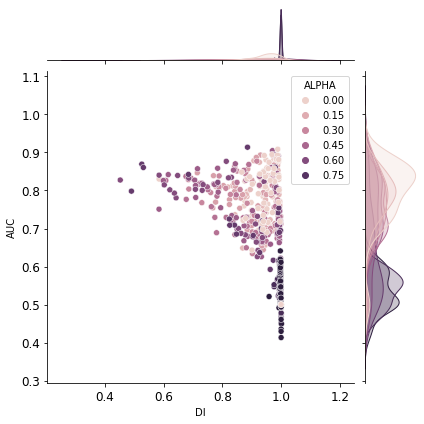

In [128]:
import seaborn as sns 
sns.jointplot(data=f, x="DI", y="AUC", hue="ALPHA")

In [12]:
np.log(3.5)

1.252762968495368